# Few-shot learning expansion of the project based on the German Traffic Sign Detection Benchmark (GTSDB)

# Plan

1. Introduction and Problem Statement
2. Setup and Environment Preparation
3. Function Definitions
   - 3.1 Data loading functions
   - 3.2 Data splitting functions
   - 3.3 Data augmentation functions
   - 3.4 Dataset preparation functions
   - 3.5 Model training functions
   - 3.6 Evaluation functions
4. Data loading, splitting and augmentation (applying the functions)
5. Model Training - YOLO without augmentation
6. Model Training - YOLO with augmentation
7. Model Evaluation and Conclusion

#1. Introduction and Problem Statement




*   This notebook extends our traffic sign detection work by applying the best-performing standard model (YOLO) to few-shot classes - the 17 sign types with fewer than 13 samples (averaging 6.4 samples per class).
*   We focus solely on the modifications and extensions to our baseline approach, referring readers to our standard notebook for the complete data exploration and implementation details.

#2. Setup and Environment Preparation

*   **Configuration Differences**: Maintained same environment and workflow as standard notebook, but configured to include 14 few-shot classes (those with < 13 samples, excluding classes with only 2 samples) alongside standard classes, with additional flags to skip regenerating completed augmentations (SKIP_AUGMENTATION=TRUE) and visualize augmentation results in the notebook (VISUALIZE_AUGMENTATIONS=TRUE).

In [ ]:
# Import necessary libraries
import locale
locale.getpreferredencoding = lambda: 'UTF-8'

In [ ]:
#!pip install -U openmim
#!mim install mmcv-full

!pip install tqdm
!pip install ultralytics

In [ ]:
# ================= Standard Libraries =================
import os
import glob
import random
import shutil
import time
import datetime
from collections import Counter, defaultdict
from pathlib import Path
from typing import List, Dict

# ================= Third-Party Libraries =================
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import yaml
from google.colab import drive
from matplotlib.patches import Patch
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm
from ultralytics import YOLO, RTDETR

# Mount Google Drive (Colab-specific)
drive.mount('/content/drive', force_remount=True)

# -----------------------------------------------------------------------------------------------------------------------------

# Define mapping of class IDs to descriptions and categories (based on ReadMe.txt)
class_info = {
    0: ("Speed limit 20", "prohibitory"),
    1: ("Speed limit 30", "prohibitory"),
    2: ("Speed limit 50", "prohibitory"),
    3: ("Speed limit 60", "prohibitory"),
    4: ("Speed limit 70", "prohibitory"),
    5: ("Speed limit 80", "prohibitory"),
    6: ("Restriction ends 80", "other"),
    7: ("Speed limit 100", "prohibitory"),
    8: ("Speed limit 120", "prohibitory"),
    9: ("No overtaking", "prohibitory"),
    10: ("No overtaking (trucks)", "prohibitory"),
    11: ("Priority at next intersection", "danger"),
    12: ("Priority road", "other"),
    13: ("Give way", "other"),
    14: ("Stop", "other"),
    15: ("No traffic both ways", "prohibitory"),
    16: ("No trucks", "prohibitory"),
    17: ("No entry", "other"),
    18: ("Danger", "danger"),
    19: ("Bend left", "danger"),
    20: ("Bend right", "danger"),
    21: ("Bend", "danger"),
    22: ("Uneven road", "danger"),
    23: ("Slippery road", "danger"),
    24: ("Road narrows", "danger"),
    25: ("Construction", "danger"),
    26: ("Traffic signal", "danger"),
    27: ("Pedestrian crossing", "danger"),
    28: ("School crossing", "danger"),
    29: ("Cycles crossing", "danger"),
    30: ("Snow", "danger"),
    31: ("Animals", "danger"),
    32: ("Restriction ends", "other"),
    33: ("Go right", "mandatory"),
    34: ("Go left", "mandatory"),
    35: ("Go straight", "mandatory"),
    36: ("Go right or straight", "mandatory"),
    37: ("Go left or straight", "mandatory"),
    38: ("Keep right", "mandatory"),
    39: ("Keep left", "mandatory"),
    40: ("Roundabout", "mandatory"),
    41: ("Restriction ends (overtaking)", "other"),
    42: ("Restriction ends (overtaking trucks)", "other")
}

Mounted at /content/drive


In [ ]:
# Define paths
base_path = "/content/drive/My Drive"
annotations_path = os.path.join(base_path, "annotations/gt.txt")
converted_path = os.path.join(base_path, "convert_images")

In [ ]:
# Global Configuration Settings
x = 13 # Standard class / Few shot learning threshold

INCLUDE_STANDARD_DATA = False # We use the background of standard classes to paste the signs from the few-shot classes for augmentation
INCLUDE_FEW_SHOT_CLASSES = [0, 16, 20, 21, 24, 27, 29, 32, 34, 36, 39, 40, 41, 42] # All few shot classes included except ones with 2 samples only

SKIP_AUGMENTATION = True # Set to TRUE when augmentations are completed.
VISUALIZE_AUGMENTATIONS = True
INCLUDE_AUGMENTATIONS = True # Control whether augmentations are included at all

#3. Function Definitions

##3.1 Data loading functions

In [ ]:
# LabelMapper class
class LabelMapper:
    def __init__(self):
        self.label_to_id = {}
        self.id_to_label = {}

    def fit(self, classes):
        self.label_to_id = {label: idx for idx, label in enumerate(classes)}
        self.id_to_label = {idx: label for label, idx in self.label_to_id.items()}

    def transform(self, labels):
        # Handle both single values and lists
        if isinstance(labels, (list, tuple, np.ndarray)):  # Check if iterable
            return [self.label_to_id[label] for label in labels]
        else:  # Single value
            return self.label_to_id[labels]

    def inverse_transform(self, ids):
        # Handle both single values and lists
        if isinstance(ids, (list, tuple, np.ndarray)):
            return [self.id_to_label[id] for id in ids]
        else:
            return self.id_to_label[ids]

In [ ]:
def load_dataset_parameterized(x=x):
    """
    Load dataset with mapping to sequential IDs for included classes.
    Returns: (standard_data, few_shot_data, mapper)
    """
    with open(annotations_path, 'r') as f:
        annotations = f.readlines()

    # First pass: Class analysis
    class_counts = defaultdict(int)
    for anno in annotations:
        parts = anno.strip().split(';')
        if len(parts) == 6:
            class_counts[int(parts[5])] += 1

    # Categorize classes
    standard_classes = [c for c, cnt in class_counts.items() if cnt >= x]
    few_shot_classes = [c for c, cnt in class_counts.items() if cnt < x]

    # Determine included classes
    included_classes = []
    if INCLUDE_STANDARD_DATA:
        included_classes.extend(standard_classes)
    if INCLUDE_FEW_SHOT_CLASSES:
        included_classes.extend([c for c in few_shot_classes
                               if c in INCLUDE_FEW_SHOT_CLASSES or str(c) in INCLUDE_FEW_SHOT_CLASSES])

    # Create mapper for included classes - using sorted to ensure consistent mapping
    mapper = LabelMapper()
    mapper.fit(sorted(included_classes))

    # Second pass: Build datasets with mapping
    standard_data, few_shot_data = [], []
    processed_images = set()

    for anno in annotations:
        parts = anno.strip().split(';')
        if len(parts) != 6:
            continue

        img_file = parts[0]
        coords = [int(parts[i]) for i in range(1, 5)]
        original_class = int(parts[5])

        # Skip classes not in included set
        if original_class not in included_classes:
            continue

        # Create mapped annotation
        annotation = {
            'img_path': os.path.join(converted_path, img_file.replace('.ppm', '.png')),
            'bbox': coords,
            'original_class': original_class,
            'class_id': mapper.transform(original_class)  # Sequential ID
        }

        # Categorize based on original class counts
        if original_class in standard_classes:
            standard_data.append(annotation)
        else:
            few_shot_data.append(annotation)

        processed_images.add(annotation['img_path'])

    print(f"Class Mapping: {mapper.label_to_id}")
    return standard_data, few_shot_data, mapper

## 3.2 Data splitting functions

*   **Guaranteed Representation Strategy**: Unlike the standard approach which performs pure stratified allocation, the few-shot splitter implements explicit minimum guarantees at the image level, allocating exactly one image per split for classes with 3+ images while strategically placing extremely rare classes (1-2 images total) exclusively in training or training+validation to maximize learning potential.


In [ ]:
# Data Splitting : create_stratified_split_with_guarantees
def create_stratified_split_with_guarantees(data, val_ratio=0.10, test_ratio=0.30, min_per_split=1, seed=42):
    """
    Creates stratified splits at the IMAGE LEVEL with minimum class guarantees.

    Parameters:
        data: List of annotation dictionaries
        val_ratio: Target ratio for validation set
        test_ratio: Target ratio for test set
        min_per_split: Minimum samples per class per split (default=1)
        seed: Random seed for reproducibility

    Notes:
        - Classes with >= 3*min_per_split samples will have guaranteed representation in all splits
        - Classes with only 2 samples will be in train+val or train+test (not all 3 splits)
        - Classes with only 1 sample will only be in the training set
    """
    # Set random seed for reproducibility
    random.seed(seed)
    np.random.seed(seed)

    # Group annotations by image
    image_groups = defaultdict(list)
    for anno in data:
        image_groups[anno['img_path']].append(anno)

    # Find dominant class for each image
    image_dominant_classes = {}
    for path, annos in image_groups.items():
        class_counts = defaultdict(int)
        for a in annos:
            class_counts[a['class_id']] += 1
        image_dominant_classes[path] = max(class_counts, key=class_counts.get)

    # Group images by their dominant class
    class_to_images = defaultdict(list)
    for path, dominant_class in image_dominant_classes.items():
        class_to_images[dominant_class].append(path)

    # Print diagnostic info
    print("\nClass distribution at IMAGE level:")
    for class_id, images in class_to_images.items():
        print(f"Class {class_id}: {len(images)} images")

    # Initialize split containers
    train_paths, val_paths, test_paths = [], [], []

    # Track classes with insufficient samples
    insufficient_classes = {}

    # First, ensure minimum representation in all splits for classes with enough samples
    for class_id, images in class_to_images.items():
        # Shuffle the images for this class
        shuffled_images = images.copy()
        random.shuffle(shuffled_images)

        if len(shuffled_images) >= min_per_split * 3:
            # Enough samples to guarantee min_per_split in each split
            test_paths.extend(shuffled_images[:min_per_split])
            val_paths.extend(shuffled_images[min_per_split:min_per_split*2])

            # Remaining images will be distributed proportionally later
            class_to_images[class_id] = shuffled_images[min_per_split*2:]
        else:
            # Not enough samples to guarantee minimum in all splits
            insufficient_classes[class_id] = len(shuffled_images)

            if len(shuffled_images) == 0:
                continue  # No images (shouldn't happen normally)
            elif len(shuffled_images) == 1:
                # Just one image, put in training
                train_paths.extend(shuffled_images)
                class_to_images[class_id] = []
            elif len(shuffled_images) == 2:
                # Two images: put one in train, one in val (need validation more than test)
                train_paths.append(shuffled_images[0])
                val_paths.append(shuffled_images[1])
                class_to_images[class_id] = []
            else:  # 3 or more but less than min_per_split*3
                # Put one in each split
                test_paths.append(shuffled_images[0])
                val_paths.append(shuffled_images[1])
                train_paths.extend(shuffled_images[2:])
                class_to_images[class_id] = []

    # Now distribute remaining images proportionally to maintain target ratios
    remaining_images = []
    for images in class_to_images.values():
        remaining_images.extend(images)

    # Shuffle again for good measure
    random.shuffle(remaining_images)

    # Calculate target sizes based on ratios
    total_remaining = len(remaining_images)
    target_test = int(total_remaining * test_ratio)
    target_val = int(total_remaining * val_ratio)

    # Allocate remaining images
    test_paths.extend(remaining_images[:target_test])
    val_paths.extend(remaining_images[target_test:target_test+target_val])
    train_paths.extend(remaining_images[target_test+target_val:])

    # Convert paths back to annotations
    train_data = [anno for path in train_paths for anno in image_groups[path]]
    val_data = [anno for path in val_paths for anno in image_groups[path]]
    test_data = [anno for path in test_paths for anno in image_groups[path]]

    # Print summary
    print(f"\nSplit results: {len(train_paths)} training images, {len(val_paths)} validation images, {len(test_paths)} test images")

    if insufficient_classes:
        print("\nWarning: Some classes have too few samples to guarantee representation in all splits:")
        for class_id, count in insufficient_classes.items():
            print(f"  Class {class_id}: only {count} images available")

    return train_data, val_data, test_data

##3.3 Data augmentation functions

*   **Adaptive Few-Shot Augmentation**: Targets exclusively the underrepresented few-shot traffic sign classes with a frequency-based approach - generating more examples (up to 15) for very rare classes with ≤4 samples and fewer (5-10) for more common classes - to address class imbalance.
*   **Context-Aware Sign Placement**: Implements a semantic replacement strategy that extracts traffic signs from few-shot images and places them onto appropriate backgrounds from standard class images, using a detailed mapping system to ensure signs appear in realistic locations (not in the sky) and appropriate road contexts (e.g., school crossing signs replace urban speed limit signs, animal crossing signs replace rural road signs).

In [ ]:
# ONLY replace this function in your code:

def load_existing_augmentations(train_data, mapper):
    """Load existing augmented images and ADD them to training data"""

    augmentation_file = "/content/drive/My Drive/convert_images/augmented/augmented_annotations.txt"

    if not os.path.exists(augmentation_file):
        return train_data

    augmented_data = []

    with open(augmentation_file, 'r') as f:
        for line in f:
            parts = line.strip().split(';')
            if len(parts) >= 6:
                img_filename = parts[0]
                img_path = f"/content/drive/My Drive/convert_images/augmented/{img_filename}"
                bbox = [float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])]
                original_class = int(parts[5])

                # Same logic as original images: check if included, then map
                if original_class in mapper.label_to_id:
                    mapped_class = mapper.transform(original_class)

                    augmented_item = {
                        'img_path': img_path,
                        'bbox': bbox,
                        'class_id': mapped_class,
                        'original_class': original_class,
                        'source': 'augmented'
                    }
                    augmented_data.append(augmented_item)

    train_data.extend(augmented_data)
    return train_data

In [ ]:
def semantic_sign_replacement(few_shot_data, standard_data, class_info, num_augmentations_per_sample=None, visualize=True):
    """
    VERSION CORRIGÉE - Semantically-aware traffic sign augmentation with FIXED bbox coordinates
    SAVES ORIGINAL CLASS IDs in annotations (no mapping applied during generation)
    FIXES: Ensures bounding boxes match exactly where signs are placed

    Args:
        few_shot_data: List of dictionaries with few-shot sample data
        standard_data: List of dictionaries with standard sample data
        class_info: Dictionary mapping class IDs to (name, type) tuples
        num_augmentations_per_sample: Number of augmentations per sample, or None for adaptive
        visualize: Whether to visualize sample augmentations

    Returns:
        List of dictionaries with augmented data
    """
    import cv2
    import os
    import numpy as np
    import random
    from tqdm import tqdm
    import albumentations as A
    from collections import defaultdict
    import matplotlib.pyplot as plt

    print("🔧 Starting FIXED semantic sign replacement with ORIGINAL class IDs...")

    # Track few-shot classes using ORIGINAL class IDs (not mapped)
    few_shot_original_classes = set([item['original_class'] for item in few_shot_data])
    standard_original_classes = set([item['original_class'] for item in standard_data
                                  if item['original_class'] not in few_shot_original_classes])

    print(f"Few-shot original classes: {sorted(few_shot_original_classes)}")
    print(f"Standard original classes: {sorted(standard_original_classes)}")

    # Semantic replacement map using ORIGINAL class IDs
    sign_replacement_map = {
        # Speed limits by road type
        0: [1],                  # 0km/h can only replace 30km/h signs
        1: [0],                  # 30km/h can only replace 20km/h signs

        # Rural signs - strict placement
        31: [4, 5],           # Animal crossing replaces 70-80km/h signs as this is more outside city centers

        # Urban crossings - urban speed limits
        27: [0, 1, 2, 27, 29], # Pedestrian crossings replace low speed limit signs or other crossings
        28: [0, 1, 2, 27, 29], # School crossings replace low speed limit signs or other crossings
        29: [0, 1, 2, 27, 28], # Cycle crossings replace low speed limit signs or other crossings

        # Curves and road features
        19: [3, 4], # Bend left replaces speed limit 60 or 70 (highways which are 80+ have less of these, and you don't need a notification in a city)
        20: [3, 4], # Bend right replaces speed limit 60 or 70 (highways which are 80+ have less of these, and you don't need a notification in a city))
        21: [3, 4], # Bend replaces speed limit 60 or 70 (highways which are 80+ have less of these, and you don't need a notification in a city))
        24: [3, 4], # Road narrows replaces speed limit 60 or 70 (highways which are 80+ have less of these, and you don't need a notification in a city))

        # Direction signs
        34: [1, 2], # Go left is in urban areas so 30-50 speed limits
        36: [1, 2], # Go right/straight is in urban areas so 30-50 speed limits
        37: [1, 2], # Go left/straight is in urban areas so 30-50 speed limits
        39: [38], # Keep left replaces keep right as this particular traffic sign is close to the ground (in contrast to others that are placed much higher)
        40:  [11, 13, 14], # ONLY intersection controls: 11: "Priority at next intersection", 13: "Give way", 14: "Stop"

        # Other signs - general replacements
        16: [15, 17],            # No trucks replaces other prohibitions
        32: [6, 41, 42],         # Restriction ends general
        41: [6, 32, 42],         # Restriction ends (overtaking)
        42: [6, 32, 41]          # Restriction ends (overtaking trucks)
    }

    # Count original samples per class for adaptive augmentation
    orig_class_counts = defaultdict(int)
    for item in few_shot_data:
        orig_class_counts[item['original_class']] += 1

    # Group standard data by ORIGINAL class ID (not mapped)
    standard_by_class = defaultdict(list)
    for item in standard_data:
        original_class = item['original_class']
        # Skip few-shot classes to prevent contamination
        if original_class in few_shot_original_classes:
            continue
        standard_by_class[original_class].append(item)

    # Print standard data distribution
    print("Standard data distribution by original class:")
    for cls, items in standard_by_class.items():
        class_name = class_info.get(cls, ('Unknown', ''))[0]
        print(f"  Class {cls} ({class_name}): {len(items)} examples")

    # Prepare results
    augmented_data = []
    visualization_samples = {}

    # Track augmentation annotations for saving (ORIGINAL class IDs)
    augmentation_annotations = []

    # Process each few-shot sample
    for item in tqdm(few_shot_data, desc="Creating FIXED semantic augmentations"):
        original_class = item['original_class']  # Use ORIGINAL class ID for logic
        mapped_class_id = item['class_id']  # Keep mapped ID for returned data structure

        # Display info about the class being processed
        class_name = class_info.get(original_class, ('Unknown', ''))[0]
        print(f"🔧 Processing original class {original_class} ({class_name})")

        # Get replaceable standard classes for this few-shot class
        replaceable_classes = sign_replacement_map.get(original_class, [])
        if not replaceable_classes:
            print(f"Warning: No replacement mapping for class {original_class} ({class_name}). Skipping.")
            continue

        # Determine augmentation count based on sample frequency
        if num_augmentations_per_sample is None:
            if orig_class_counts[original_class] <= 4:
                num_augs = 15  # Very few samples
            elif orig_class_counts[original_class] <= 8:
                num_augs = 10  # Few samples
            else:
                num_augs = 5   # More samples
        else:
            num_augs = num_augmentations_per_sample

        # Gather all potential backgrounds from replaceable classes
        potential_backgrounds = []
        for std_class in replaceable_classes:
            potential_backgrounds.extend(standard_by_class.get(std_class, []))

        # If not enough backgrounds, reduce augmentation count
        if len(potential_backgrounds) < num_augs:
            original_num = num_augs
            num_augs = min(len(potential_backgrounds), num_augs)
            print(f"Warning: Not enough backgrounds for class {original_class}. " +
                  f"Reduced from {original_num} to {num_augs} augmentations.")

        # Skip if no suitable backgrounds
        if len(potential_backgrounds) == 0:
            print(f"Error: No suitable backgrounds for class {original_class}. Skipping.")
            continue

        # Shuffle potential backgrounds
        random.shuffle(potential_backgrounds)

        # Extract sign image
        img = cv2.imread(item['img_path'])
        if img is None:
            print(f"Warning: Could not read image {item['img_path']}")
            continue

        x1, y1, x2, y2 = item['bbox']
        sign_img = img[y1:y2, x1:x2].copy()

        print(f"   📐 Source sign bbox: ({x1},{y1}) to ({x2},{y2}), size: {x2-x1}x{y2-y1}")

        # Create augmentations
        successful_augs = 0
        item_augmentations = []

        for placement in potential_backgrounds[:num_augs*2]:  # Get twice as many to allow for failures
            if successful_augs >= num_augs:
                break

            try:
                # Load background image
                bg_img = cv2.imread(placement['img_path'])
                if bg_img is None:
                    continue

                # 🔧 CRITICAL FIX: Get target location where we'll place the NEW sign
                target_x1, target_y1, target_x2, target_y2 = placement['bbox']
                target_w = target_x2 - target_x1
                target_h = target_y2 - target_y1

                print(f"   📐 Target location: ({target_x1},{target_y1}) to ({target_x2},{target_y2}), size: {target_w}x{target_h}")

                # Resize our sign to fit the target space
                resized_sign = cv2.resize(sign_img, (target_w, target_h), interpolation=cv2.INTER_AREA)

                # Apply mild augmentation to prevent overfitting
                transform = A.Compose([
                    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.7),
                    A.HueSaturationValue(hue_shift_limit=3, sat_shift_limit=10, val_shift_limit=10, p=0.5),
                    A.GaussianBlur(blur_limit=(1, 2), p=0.3),
                ])
                aug_sign = transform(image=resized_sign)['image']

                # 🔧 CRITICAL: Create result image by placing sign at target location
                result_img = bg_img.copy()

                # VERIFICATION: Ensure the placement coordinates are within image bounds
                bg_h, bg_w = bg_img.shape[:2]
                if target_x2 > bg_w or target_y2 > bg_h or target_x1 < 0 or target_y1 < 0:
                    print(f"   ❌ Target coordinates out of bounds: image {bg_w}x{bg_h}, target ({target_x1},{target_y1})-({target_x2},{target_y2})")
                    continue

                # Place the augmented sign at the target location
                result_img[target_y1:target_y2, target_x1:target_x2] = aug_sign

                print(f"   ✅ Placed sign at ({target_x1},{target_y1})-({target_x2},{target_y2})")

                # Save the augmented image
                aug_dir = os.path.join(os.path.dirname(item['img_path']), "augmented")
                os.makedirs(aug_dir, exist_ok=True)

                # 🔧 FIXED: Include background name and use PNG format
                source_name = os.path.splitext(os.path.basename(item['img_path']))[0]
                background_name = os.path.splitext(os.path.basename(placement['img_path']))[0]
                aug_filename = f"{source_name}_semantic_augmentation{successful_augs}_background_{background_name}.png"
                aug_path = os.path.join(aug_dir, aug_filename)
                cv2.imwrite(aug_path, result_img)

                # 🔧 CRITICAL FIX: Save the EXACT coordinates where we placed the sign
                # These coordinates should match exactly where the sign is in the result image
                print(f"   💾 Saving annotation: {aug_filename} with coordinates ({target_x1},{target_y1})-({target_x2},{target_y2}) and class {original_class}")
                annotation_line = f"{aug_filename};{target_x1};{target_y1};{target_x2};{target_y2};{original_class}"
                augmentation_annotations.append(annotation_line)

                   # Add to augmented data with BOTH original and mapped IDs
                aug_item = {
                    'img_path': aug_path,
                    'bbox': [target_x1, target_y1, target_x2, target_y2],  # EXACT coordinates where sign was placed
                    'original_class': original_class,  # Original class for semantics
                    'class_id': mapped_class_id,  # Mapped ID for current pipeline
                    'replaced_class': placement['original_class']  # For visualization
                }

                augmented_data.append(aug_item)
                item_augmentations.append(aug_item)

                successful_augs += 1
                replaced_name = class_info.get(placement['original_class'], ('Unknown', ''))[0]
                print(f"   ✅ Created aug {successful_augs} replacing class {placement['original_class']} ({replaced_name})")

            except Exception as e:
                print(f"   ❌ Error creating augmentation: {str(e)}")

        # Store augmentations for visualization
        if item_augmentations:
            visualization_samples[item['img_path']] = {
                'original': item,
                'augmentations': item_augmentations
            }

        print(f"✅ Created {successful_augs} augmentations for class {original_class} ({class_name})")

    # Save all augmentation annotations to a file (with ORIGINAL class IDs)
    if augmentation_annotations:
        # Save annotations file in the first augmented directory found
        first_aug_dir = None
        for item in few_shot_data:
            potential_dir = os.path.join(os.path.dirname(item['img_path']), "augmented")
            if os.path.exists(potential_dir):
                first_aug_dir = potential_dir
                break

        if first_aug_dir:
            annotations_file = os.path.join(first_aug_dir, "augmented_annotations.txt")
            with open(annotations_file, 'w') as f:
                for line in augmentation_annotations:
                    f.write(line + '\n')
            print(f"\n💾 Saved {len(augmentation_annotations)} augmentation annotations to {annotations_file}")
            print("📄 Sample annotations saved (with original class IDs):")
            for line in augmentation_annotations[:3]:  # Show first 3
                print(f"   {line}")

    # Print augmentation statistics
    aug_class_counts = defaultdict(int)
    for item in augmented_data:
        aug_class_counts[item['original_class']] += 1

    print("\n📊 Augmentation Statistics:")
    print(f"Original few-shot samples: {len(few_shot_data)}")
    print(f"Generated augmented samples: {len(augmented_data)}")

    print("\nClass distribution after augmentation:")
    for original_class in sorted(few_shot_original_classes):
        if original_class in class_info:
            name = class_info[original_class][0]
            print(f"Class {original_class} ({name}): {orig_class_counts[original_class]} original + " +
                f"{aug_class_counts[original_class]} augmented = {orig_class_counts[original_class] + aug_class_counts[original_class]} total")

    # Visualize if requested
    if visualize and visualization_samples:
        def visualize_augmentations(original_item, augmented_items, max_display=3):
            """
            Visualize original image and its augmentations side by side.
            """
            # Read original image
            orig_img = cv2.imread(original_item['img_path'])
            if orig_img is None:
                print(f"Could not read original image: {original_item['img_path']}")
                return

            orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

            # Determine number of augmentations to show
            num_aug = min(len(augmented_items), max_display)

            # No augmentations case
            if num_aug == 0:
                plt.figure(figsize=(6, 6))
                plt.imshow(orig_img)
                x1, y1, x2, y2 = original_item['bbox']
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                    linewidth=2, edgecolor='green', facecolor='none')
                plt.gca().add_patch(rect)
                original_class = original_item['original_class']
                class_name = class_info[original_class][0] if original_class in class_info else f"Unknown ({original_class})"
                plt.title(f"Original (Class {original_class}: {class_name})\nNo augmentations created")
                plt.axis('off')
                plt.tight_layout()
                plt.show()
                return

            # Create figure with subplots
            fig, axes = plt.subplots(1, num_aug + 1, figsize=(5 * (num_aug + 1), 5))

            # Handle case with only one subplot
            if num_aug == 0:
                axes.imshow(orig_img)
                x1, y1, x2, y2 = original_item['bbox']
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                    linewidth=2, edgecolor='green', facecolor='none')
                axes.add_patch(rect)
                original_class = original_item['original_class']
                class_name = class_info[original_class][0] if original_class in class_info else f"Unknown ({original_class})"
                axes.set_title(f"Original (Class {original_class}: {class_name})")
                axes.axis('off')
            else:
                # Display original in first subplot
                if isinstance(axes, np.ndarray):
                    # Multiple subplots case
                    ax_orig = axes[0]
                else:
                    # Single subplot case
                    ax_orig = axes

                ax_orig.imshow(orig_img)
                x1, y1, x2, y2 = original_item['bbox']
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                    linewidth=2, edgecolor='green', facecolor='none')
                ax_orig.add_patch(rect)
                original_class = original_item['original_class']
                class_name = class_info[original_class][0] if original_class in class_info else f"Unknown ({original_class})"
                ax_orig.set_title(f"Original (Class {original_class}: {class_name})")
                ax_orig.axis('off')

                # Display augmentations
                for i in range(num_aug):
                    aug_item = augmented_items[i]
                    aug_img = cv2.imread(aug_item['img_path'])
                    if aug_img is None:
                        if isinstance(axes, np.ndarray):
                            axes[i+1].text(0.5, 0.5, "Error loading image",
                                        horizontalalignment='center',
                                        verticalalignment='center')
                            continue
                        else:
                            print(f"Could not read augmented image: {aug_item['img_path']}")
                            continue

                    aug_img = cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB)

                    if isinstance(axes, np.ndarray):
                        ax = axes[i+1]
                    else:
                        # Should not happen with num_aug > 0
                        continue

                    ax.imshow(aug_img)

                    # Draw bbox
                    x1, y1, x2, y2 = aug_item['bbox']
                    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                        linewidth=2, edgecolor='green', facecolor='none')
                    ax.add_patch(rect)

                    # Add title with replacement info
                    replaced_class = aug_item.get('replaced_class')
                    replaced_name = class_info[replaced_class][0] if replaced_class in class_info else f"Unknown ({replaced_class})"
                    ax.set_title(f"Aug {i+1}\nReplaced: {replaced_class} ({replaced_name})")
                    ax.axis('off')

            plt.tight_layout()
            plt.show()

        print("\nVisualizing sample augmentations...")

        # Priority classes to visualize first (potentially problematic ones)
        priority_classes = [31, 27, 0]  # Animal crossing, Pedestrian, Speed 20

        # Show one sample from each priority class
        for original_class in priority_classes:
            if original_class in few_shot_original_classes:
                for img_path, sample in visualization_samples.items():
                    if sample['original']['original_class'] == original_class:
                        class_name = class_info[original_class][0] if original_class in class_info else f"Unknown ({original_class})"
                        print(f"\nVisualizing priority class {original_class} ({class_name})")
                        visualize_augmentations(sample['original'], sample['augmentations'][:3])
                        break

        # Then show other samples
        shown_classes = set(priority_classes)
        remaining_samples = 3  # Show up to 3 more examples

        for img_path, sample in visualization_samples.items():
            original_class = sample['original']['original_class']
            if original_class not in shown_classes and len(sample['augmentations']) > 0:
                class_name = class_info[original_class][0] if original_class in class_info else f"Unknown ({original_class})"
                print(f"\nVisualizing class {original_class} ({class_name})")
                visualize_augmentations(sample['original'], sample['augmentations'][:3])
                shown_classes.add(original_class)
                remaining_samples -= 1

                if remaining_samples <= 0:
                    break

    return augmented_data

In [ ]:
def visualize_augmentations(original_item, augmented_items, max_display=3):
    """
    Visualize original image and its augmentations side by side.
    """
    # Read original image
    orig_img = cv2.imread(original_item['img_path'])
    if orig_img is None:
        print(f"Could not read original image: {original_item['img_path']}")
        return

    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    # Determine number of augmentations to show
    num_aug = min(len(augmented_items), max_display)

    # Create figure
    fig, axes = plt.subplots(1, num_aug + 1, figsize=(4 * (num_aug + 1), 4))

    # Display original
    axes[0].imshow(orig_img)
    x1, y1, x2, y2 = original_item['bbox']
    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                        linewidth=2, edgecolor='green', facecolor='none')
    axes[0].add_patch(rect)
    axes[0].set_title("Original")
    axes[0].axis('off')

    # Display augmentations
    for i in range(num_aug):
        aug_img = cv2.imread(augmented_items[i]['img_path'])
        if aug_img is None:
            axes[i+1].text(0.5, 0.5, "Error loading image",
                          horizontalalignment='center',
                          verticalalignment='center')
            continue

        aug_img = cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB)
        axes[i+1].imshow(aug_img)

        # Draw bbox
        x1, y1, x2, y2 = augmented_items[i]['bbox']
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                            linewidth=2, edgecolor='green', facecolor='none')
        axes[i+1].add_patch(rect)
        axes[i+1].set_title(f"Augmentation {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

## 3.4 Dataset preparation functions

*   **Integrated Processing Pipeline**: Implements a comprehensive workflow function that handles the entire data preparation sequence - loading data, excluding classes with fewer than 3 samples, creating stratified train/validation/test splits, and managing few-shot augmentation - with configurable parameters that allow excluding augmentations entirely (INCLUDE_AUGMENTATIONS=False), skipping generation of new augmentations while using existing ones (SKIP_AUGMENTATION=True), or selecting specific classes to process (INCLUDE_FEW_SHOT_CLASSES).

In [ ]:
def apply_improved_augmentation_pipeline():
    """
    Complete pipeline that properly combines original and augmented data
    """
    # 1. Load original data
    standard_data, few_shot_data, mapper = load_dataset_parameterized(x=x)

    # 2. Filter and combine datasets based on configuration
    combined_data = []

    if INCLUDE_STANDARD_DATA:
        combined_data.extend(standard_data)

    if INCLUDE_FEW_SHOT_CLASSES:
        # Filter few_shot_data to only include specified classes
        filtered_few_shot = [item for item in few_shot_data
                           if item['original_class'] in INCLUDE_FEW_SHOT_CLASSES
                           or str(item['original_class']) in INCLUDE_FEW_SHOT_CLASSES]

        print(f"\nIncluding {len(filtered_few_shot)} few-shot samples...")
        combined_data.extend(filtered_few_shot)

    # 3. Exclude classes with fewer than 3 samples
    class_counts = defaultdict(int)
    for item in combined_data:
        class_counts[item['class_id']] += 1

    excluded_classes = [class_id for class_id, count in class_counts.items() if count < 3]

    if excluded_classes:
        print(f"\nExcluding {len(excluded_classes)} classes with fewer than 3 samples:")
        for class_id in excluded_classes:
            orig_class = mapper.id_to_label[class_id]
            class_name = class_info.get(orig_class, ('Unknown', ''))[0]
            print(f"  Class {class_id} (original ID: {orig_class}, '{class_name}'): only {class_counts[class_id]} samples")

        # Filter out the excluded classes
        filtered_data = [item for item in combined_data if item['class_id'] not in excluded_classes]
        print(f"Removed {len(combined_data) - len(filtered_data)} samples from excluded classes")
        combined_data = filtered_data

    # 4. Create the train/val/test split using the stratified split with guarantees
    if len(combined_data) > 0:
        train_data, val_data, test_data = create_stratified_split_with_guarantees(
            combined_data,
            min_per_split=1,
            seed=42
        )

        # Analyze class distribution after splitting
        print("\nClass distribution in splits:")
        train_classes = set(item['class_id'] for item in train_data)
        val_classes = set(item['class_id'] for item in val_data)
        test_classes = set(item['class_id'] for item in test_data)

        all_classes = sorted(set(item['class_id'] for item in combined_data))
        for class_id in all_classes:
            in_train = class_id in train_classes
            in_val = class_id in val_classes
            in_test = class_id in test_classes
            orig_class = mapper.id_to_label[class_id]
            class_name = class_info.get(orig_class, ('Unknown', ''))[0]
            print(f"Class {class_id} (original ID: {orig_class}, '{class_name}'): " +
                  f"{'✓' if in_train else '✗'} train, " +
                  f"{'✓' if in_val else '✗'} val, " +
                  f"{'✓' if in_test else '✗'} test")
    else:
        raise ValueError("No data left after filtering. Consider including more classes or standard data.")

    # 5. Load existing augmentations and ADD them to training data
    if INCLUDE_AUGMENTATIONS and INCLUDE_FEW_SHOT_CLASSES:
        if SKIP_AUGMENTATION:
            print("Skipping new augmentation generation.")
            print("Looking for existing augmented images...")
            train_data = load_existing_augmentations(train_data, mapper)

            original_count = sum(1 for item in train_data if item.get('source') != 'augmented')
            augmented_count = sum(1 for item in train_data if item.get('source') == 'augmented')
            print(f"🔍 APRÈS load_existing_augmentations: {len(train_data)} total ({original_count} orig, {augmented_count} aug)")

        else:
            # Find few-shot samples in the training set
            train_few_shot = [item for item in train_data
                            if item['original_class'] in INCLUDE_FEW_SHOT_CLASSES
                            or str(item['original_class']) in INCLUDE_FEW_SHOT_CLASSES]

            print(f"\nAugmenting {len(train_few_shot)} few-shot samples in the training set...")

            # Use semantic augmentation only on training data
            augmented_data = semantic_sign_replacement(
                train_few_shot,
                standard_data,
                class_info,
                num_augmentations_per_sample=None,
                visualize=VISUALIZE_AUGMENTATIONS
            )

            # Add augmented data to training set
            train_data.extend(augmented_data)

            # Print augmentation statistics
            orig_class_counts = defaultdict(int)
            aug_class_counts = defaultdict(int)

            for item in train_few_shot:
                orig_class_counts[item['class_id']] += 1

            for item in augmented_data:
                aug_class_counts[item['class_id']] += 1

            print("\nAugmentation Statistics:")
            print(f"Original few-shot samples in training: {len(train_few_shot)}")
            print(f"Generated augmented samples: {len(augmented_data)}")
            print(f"Total training set size: {len(train_data)}")

            print("\nClass distribution in training set after augmentation:")
            for class_id, count in orig_class_counts.items():
                if aug_class_counts[class_id] > 0:
                    orig_class = mapper.id_to_label[class_id]
                    class_name = class_info.get(orig_class, ('Unknown', ''))[0]
                    print(f"Class {class_id} (original ID: {orig_class}, '{class_name}'): {count} original + {aug_class_counts[class_id]} augmented = {count + aug_class_counts[class_id]} total")
    else:
        print("Augmentations disabled - using only original images for training.")

    return train_data, val_data, test_data, mapper

In [ ]:
def prepare_ultralytics_dataset(data_list, output_dir):
    """
    Prepare dataset in YOLO format for Ultralytics models (works for both YOLO and DETR)

    Args:
        data_list: List of dictionaries containing image data
        output_dir: Directory to save prepared dataset
    """
    images_dir = os.path.join(output_dir, "images")
    labels_dir = os.path.join(output_dir, "labels")
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    for idx, item in tqdm(enumerate(data_list), total=len(data_list),
                         desc=f"Preparing {os.path.basename(output_dir)}"):
        # Link or copy image
        img_path = item['img_path']
        img_filename = f"{idx:05d}.jpg"
        new_img_path = os.path.join(images_dir, img_filename)

        if os.path.exists(img_path) and not os.path.exists(new_img_path):
            try:
                os.symlink(os.path.abspath(img_path), new_img_path)
            except:
                shutil.copy(img_path, new_img_path)

        # Get image dimensions
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Cannot read image {img_path}")
            continue

        h, w = img.shape[:2]

        # Convert bbox to YOLO format
        x1, y1, x2, y2 = item['bbox']
        x_center = ((x1 + x2) / 2) / w
        y_center = ((y1 + y2) / 2) / h
        width = (x2 - x1) / w
        height = (y2 - y1) / h

        # Write label file
        with open(os.path.join(labels_dir, f"{idx:05d}.txt"), 'w') as f:
            f.write(f"{item['class_id']} {x_center} {y_center} {width} {height}\n")

In [ ]:
def setup_dataset(train_data, val_data, test_data, mapper):
    """
    Set up the entire dataset for Ultralytics models
    """
    import shutil

    print("\n🚀 SETTING UP COMPLETE DATASET")
    print("="*50)

    # Show what we're working with
    def count_sources(data, name):
        original = sum(1 for item in data if item.get('source') != 'augmented')
        augmented = sum(1 for item in data if item.get('source') == 'augmented')
        print(f"📊 {name}: {len(data)} total ({original} orig, {augmented} aug)")

    print("📊 INPUT DATASETS:")
    count_sources(train_data, "TRAIN")
    count_sources(val_data, "VAL")
    count_sources(test_data, "TEST")

    # Set up data directory - CLEAR OLD DATA FIRST
    data_dir = os.path.join(os.getcwd(), "traffic_sign_data")

    if os.path.exists(data_dir):
        shutil.rmtree(data_dir)
        print(f"🗑️ Cleared existing dataset directory")

    os.makedirs(data_dir, exist_ok=True)

    # Export datasets to Ultralytics format
    print("🔧 Preparing datasets for Ultralytics...")
    prepare_ultralytics_dataset(train_data, os.path.join(data_dir, "train"))
    prepare_ultralytics_dataset(val_data, os.path.join(data_dir, "val"))
    prepare_ultralytics_dataset(test_data, os.path.join(data_dir, "test"))

    # Create YAML config
    yaml_path = os.path.join(data_dir, "dataset.yaml")
    class_names = {i: f"class_{mapper.id_to_label[i]}" for i in range(len(mapper.id_to_label))}

    yaml_content = {
        "path": data_dir,
        "train": os.path.join(data_dir, "train/images"),
        "val": os.path.join(data_dir, "val/images"),
        "test": os.path.join(data_dir, "test/images"),
        "names": class_names
    }

    with open(yaml_path, 'w') as f:
        yaml.dump(yaml_content, f)

    print(f"✅ Created dataset configuration at {yaml_path}")

    # Verify what got created
    train_images = len([f for f in os.listdir(os.path.join(data_dir, "train/images"))
                       if f.endswith(('.jpg', '.png', '.jpeg'))])
    print(f"🎯 FINAL VERIFICATION:")
    print(f"   Training images created: {train_images}")
    print(f"   Expected from train_data: {len(train_data)}")

    if train_images != len(train_data):
        print(f"   ⚠️ Data count mismatch!")
    else:
        print(f"   ✅ Data integrity verified")

    return yaml_path

##3.5 Model training functions

Here are key differences of this YOLO model compared to the one used in the standard model:

*   **Class Imbalance Focus**: Implements critical custom gradient weighting via hooks that apply class-specific weights (inversely proportional to class frequency), explicitly addressing the few-shot learning challenge where some classes have as few as 3-7 samples.
*   **Conservative Augmentation Strategy**: Uses more restrained augmentation parameters (mosaic=0.5 vs 1.0, disabled mixup and copy-paste) with tighter color constraints (hsv_h=0.01 vs 0.03) to preserve the distinctive visual characteristics of rare traffic signs, prioritizing precision over variation for few-shot classes.

In [ ]:
def train_yolo_model_a100(train_data, val_data, test_data, mapper, results_dir, subset_mode=False):
    """
    Train a YOLOv8x model with critical class imbalance handling
    """
    import datetime
    import torch  # Add this import for the hook

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    results_dir = f"{results_dir}_A100_{timestamp}"
    os.makedirs(results_dir, exist_ok=True)
    print(f"Created A100 results directory: {results_dir}")

    yaml_path = setup_dataset(train_data, val_data, test_data, mapper)

    # Calculate class weights for gradient hook application
    class_counts = defaultdict(int)
    for item in train_data:
        class_counts[item['class_id']] += 1

    total_samples = len(train_data)
    num_classes = len(class_counts)
    class_weights = {}
    for class_id, count in class_counts.items():
        class_weights[class_id] = total_samples / (num_classes * count)

    print("Class weights calculated from training data:")
    for class_id, weight in sorted(class_weights.items()):
        orig_class = mapper.id_to_label[class_id]
        class_name = class_info.get(orig_class, ('Unknown', ''))[0]
        print(f"  Class {class_id} ({class_name}): {class_counts[class_id]} samples, weight = {weight:.2f}")

    # Prepare weights list for the gradient hook
    weights_list = [class_weights.get(i, 1.0) for i in range(40)]  # For all 40 classes

    print("\n=== Training YOLOv8x Model on A100 with Critical Imbalance Handling ===")

    # Use the extra-large model
    model = YOLO('yolov8x.pt')

    # CRITICAL ADDITION: Apply manual weight gradients via hook
    # This is the most substantive way to handle class weights since YOLOv8 doesn't have a class_weight parameter
    for name, param in model.model.named_parameters():
        if 'cls_preds' in name:  # Target classification layers
            param.register_hook(lambda grad: grad * torch.tensor(weights_list).to(grad.device))

    # Configure epochs and batch size
    if subset_mode:
        epochs = 2
        save_period = 1
        batch = 8
        workers = 2
    else:
        epochs = 50
        save_period = 1
        batch = 8
        workers = 2
    # Train with only the guaranteed working parameters
    model.train(
        data=yaml_path,
        epochs=epochs,
        imgsz=1280,
        rect=False,
        batch=batch,

        # Refined loss component weights
        cls=2.5,              # Slightly reduced to prevent overfitting
        box=8.0,              # Increased to improve box accuracy
        dfl=2.0,              # Increased to help rare class localization

        # Augmentation refinements
        augment=True,
        copy_paste=0.0,       # Reduced for rare classes
        mixup=0.0,            # Disabled for rare classes
        mosaic=0.5,          # Reduced mosaic probability

        # Color augmentation for traffic signs
        hsv_h=0.01,           # Further restricted hue changes
        hsv_s=0.3,            # Reduced saturation variation
        hsv_v=0.3,            # Reduced brightness variation

        # Geometric augmentation
        degrees=5.0,          # Reduced rotation
        translate=0.15,       # Translation
        scale=0.3,            # Reduced scale variation
        shear=2.0,            # Reduced shear
        fliplr=0.0,           # No horizontal flips

        # Training parameters - explicit settings
        lr0=0.01,             # Explicitly set initial LR
        cos_lr=True,
        amp=True,
        cache='disk',
        val=True,             # Enable validation
        patience=15,          # Increased patience for rare classes
        save_period=save_period,
        project=results_dir,
        name="yolo_traffic_signs",
        device=0,
        exist_ok=True,
        verbose=True
    )

    # Backup logic for saving best model
    final_model_path = os.path.join(results_dir, "yolo_traffic_signs", "weights", "best.pt")
    if os.path.exists(final_model_path):
        backup_path = os.path.join(results_dir, "best_model.pt")
        shutil.copy(final_model_path, backup_path)
        print(f"Saved backup of best model to: {backup_path}")

    return model, yaml_path

In [ ]:
def visualize_training_metrics(model_type='yolo', run_dir=None, save_path=None):
    """
    Create comprehensive visualizations of training metrics for YOLO or RT-DETR models.

    This function finds the most recent training run, reads the CSV logs, and creates
    a multi-panel visualization showing training and validation metrics over time.

    Parameters:
    -----------
    model_type : str
        Type of model ('yolo' or 'rt-detr')
    run_dir : str or Path, optional
        Specific run directory to use. If None, will find the most recent one.
    save_path : str or Path, optional
        Path to save the visualization. If None, the plot is displayed but not saved.

    Returns:
    --------
    fig : matplotlib.figure.Figure
        The generated figure containing all visualizations
    """
    # If specific run directory is provided, use it
    if run_dir is not None:
        results_dir = Path(run_dir)
    else:
        # Find the most recent results directory - improved logic
        base_dirs = []

        # Check all possible directories where results might be stored
        if model_type.lower() == 'yolo':
            base_dirs = ['runs/detect/train', 'runs/train']
        elif model_type.lower() == 'rt-detr':
            base_dirs = ['runs/rt-detr/train', 'runs/detect/train']
        else:  # Generic fallback
            base_dirs = ['runs']

        # Find all training directories across all possible base paths
        results_dirs = []
        for base_dir in base_dirs:
            if os.path.exists(base_dir):
                # Look for numbered train folders (train, train1, train2, etc.)
                pattern = f"{base_dir}*"
                results_dirs.extend(glob.glob(pattern))

        if not results_dirs:
            print(f"No training results found for {model_type}.")
            return None

        # Sort by modification time to get the most recent
        results_dirs.sort(key=lambda x: os.path.getmtime(x))
        results_dir = Path(results_dirs[-1])  # Most recent training run

    print(f"Using results directory: {results_dir}")

    # Look for results.csv in various possible locations
    possible_csv_paths = [
        results_dir / 'results.csv',
        results_dir / 'metrics' / 'results.csv',
    ]

    csv_file = None
    for path in possible_csv_paths:
        if path.exists():
            csv_file = path
            break

    if csv_file is None:
        print(f"No results.csv found in {results_dir} or its subdirectories")
        return None

    print(f"Using CSV file: {csv_file}")

    # Load the metrics
    df = pd.read_csv(csv_file)

    # Print available columns for debugging
    print(f"Available metrics columns: {df.columns.tolist()}")

    # Create a comprehensive multi-panel figure
    fig = plt.figure(figsize=(20, 16))
    plt.suptitle(f'{model_type.upper()} Training Metrics', fontsize=20)

    # Define grid layout
    gs = fig.add_gridspec(3, 3)

    # 1. Total Loss Plot (larger panel spanning two columns)
    ax_total_loss = fig.add_subplot(gs[0, 0:2])

    # Calculate total losses if not directly available
    if 'train/loss' in df.columns:
        train_total_loss = df['train/loss']
    else:
        # Sum available loss components
        loss_components = [col for col in df.columns if col.startswith('train/') and col.endswith('_loss')]
        train_total_loss = df[loss_components].sum(axis=1) if loss_components else None

    if 'val/loss' in df.columns:
        val_total_loss = df['val/loss']
    else:
        # Sum available loss components
        loss_components = [col for col in df.columns if col.startswith('val/') and col.endswith('_loss')]
        val_total_loss = df[loss_components].sum(axis=1) if loss_components else None

    if train_total_loss is not None:
        ax_total_loss.plot(df['epoch'], train_total_loss, 'b-', linewidth=2, label='Training Loss')
    if val_total_loss is not None:
        ax_total_loss.plot(df['epoch'], val_total_loss, 'r-', linewidth=2, label='Validation Loss')

    ax_total_loss.set_title('Total Loss', fontsize=16)
    ax_total_loss.set_xlabel('Epoch', fontsize=12)
    ax_total_loss.set_ylabel('Loss', fontsize=12)
    ax_total_loss.grid(True, linestyle='--', alpha=0.7)
    ax_total_loss.legend(fontsize=12)

    # 2. Learning Rate Plot
    ax_lr = fig.add_subplot(gs[0, 2])
    # Check for different learning rate column patterns
    lr_columns = [col for col in df.columns if col.startswith('lr/') or col == 'lr']
    if lr_columns:
        ax_lr.plot(df['epoch'], df[lr_columns[0]], 'g-', linewidth=2)
        ax_lr.set_title('Learning Rate', fontsize=16)
        ax_lr.set_xlabel('Epoch', fontsize=12)
        ax_lr.set_ylabel('Learning Rate', fontsize=12)
        ax_lr.grid(True, linestyle='--', alpha=0.7)

    # 3. Individual Loss Components
    ax_loss_components = fig.add_subplot(gs[1, 0])
    loss_components = {'train/box_loss': ('Box Loss', 'b-'),
                       'train/cls_loss': ('Class Loss', 'r-'),
                       'train/obj_loss': ('Objectness Loss', 'g-'),
                       'train/dfl_loss': ('DFL Loss', 'm-'),
                       # Add RT-DETR specific losses
                       'train/giou_loss': ('GIoU Loss', 'c-'),
                       'train/l1_loss': ('L1 Loss', 'y-')}

    for col, (label, style) in loss_components.items():
        if col in df.columns:
            ax_loss_components.plot(df['epoch'], df[col], style, linewidth=2, label=label)

    ax_loss_components.set_title('Training Loss Components', fontsize=16)
    ax_loss_components.set_xlabel('Epoch', fontsize=12)
    ax_loss_components.set_ylabel('Loss', fontsize=12)
    ax_loss_components.grid(True, linestyle='--', alpha=0.7)
    ax_loss_components.legend(fontsize=10)

    # 4. Validation Loss Components
    ax_val_loss = fig.add_subplot(gs[1, 1])
    val_components = {'val/box_loss': ('Box Loss', 'b-'),
                      'val/cls_loss': ('Class Loss', 'r-'),
                      'val/obj_loss': ('Objectness Loss', 'g-'),
                      'val/dfl_loss': ('DFL Loss', 'm-'),
                      # Add RT-DETR specific losses
                      'val/giou_loss': ('GIoU Loss', 'c-'),
                      'val/l1_loss': ('L1 Loss', 'y-')}

    for col, (label, style) in val_components.items():
        if col in df.columns:
            ax_val_loss.plot(df['epoch'], df[col], style, linewidth=2, label=label)

    ax_val_loss.set_title('Validation Loss Components', fontsize=16)
    ax_val_loss.set_xlabel('Epoch', fontsize=12)
    ax_val_loss.set_ylabel('Loss', fontsize=12)
    ax_val_loss.grid(True, linestyle='--', alpha=0.7)
    ax_val_loss.legend(fontsize=10)

    # 5. Precision and Recall
    ax_pr = fig.add_subplot(gs[1, 2])
    # Check various possible precision/recall column names
    precision_cols = [col for col in df.columns if 'precision' in col.lower()]
    recall_cols = [col for col in df.columns if 'recall' in col.lower()]

    if precision_cols:
        ax_pr.plot(df['epoch'], df[precision_cols[0]], 'b-', linewidth=2, label='Precision')
    if recall_cols:
        ax_pr.plot(df['epoch'], df[recall_cols[0]], 'r-', linewidth=2, label='Recall')

    ax_pr.set_title('Precision and Recall', fontsize=16)
    ax_pr.set_xlabel('Epoch', fontsize=12)
    ax_pr.set_ylabel('Value', fontsize=12)
    ax_pr.grid(True, linestyle='--', alpha=0.7)
    ax_pr.legend(fontsize=12)

    # 6. mAP Metrics
    ax_map = fig.add_subplot(gs[2, 0])
    # Check various possible mAP column patterns
    map50_cols = [col for col in df.columns if ('map50' in col.lower() or 'map_50' in col.lower() or 'map@0.5' in col.lower())]
    map_cols = [col for col in df.columns if ('map50-95' in col.lower() or 'map@0.5:0.95' in col.lower() or 'map' in col.lower() and '50' not in col.lower())]

    if map50_cols:
        ax_map.plot(df['epoch'], df[map50_cols[0]], 'g-', linewidth=2, label='mAP@0.5')
    if map_cols:
        # Filter out the map50 cols if they also got caught in the map_cols pattern
        map_specific = [col for col in map_cols if col not in map50_cols]
        if map_specific:
            ax_map.plot(df['epoch'], df[map_specific[0]], 'm-', linewidth=2, label='mAP@0.5:0.95')

    ax_map.set_title('Mean Average Precision', fontsize=16)
    ax_map.set_xlabel('Epoch', fontsize=12)
    ax_map.set_ylabel('mAP', fontsize=12)
    ax_map.grid(True, linestyle='--', alpha=0.7)
    ax_map.legend(fontsize=12)

    # 7. Training Speed
    ax_speed = fig.add_subplot(gs[2, 1])
    time_cols = [col for col in df.columns if 'time' in col.lower() and 'epoch' in col.lower()]
    if time_cols:
        ax_speed.plot(df['epoch'], df[time_cols[0]], 'k-', linewidth=2)
        ax_speed.set_title('Training Time per Epoch', fontsize=16)
        ax_speed.set_xlabel('Epoch', fontsize=12)
        ax_speed.set_ylabel('Seconds', fontsize=12)
        ax_speed.grid(True, linestyle='--', alpha=0.7)

    # 8. GPU Memory Usage
    ax_gpu = fig.add_subplot(gs[2, 2])
    memory_cols = [col for col in df.columns if 'mem' in col.lower() and 'gpu' in col.lower()]
    if memory_cols:
        ax_gpu.plot(df['epoch'], df[memory_cols[0]], 'r-', linewidth=2)
        ax_gpu.set_title('GPU Memory Usage', fontsize=16)
        ax_gpu.set_xlabel('Epoch', fontsize=12)
        ax_gpu.set_ylabel('MB', fontsize=12)
        ax_gpu.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust for suptitle

    # Save the figure if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Visualization saved to {save_path}")

    return fig

## 3.6 Evaluation functions

In [ ]:
def evaluate_detection_model(model, yaml_path, results_dir=None, show_images=True, max_images=5, conf_thresh=0.25):
    """
    Comprehensive evaluation with option to display and save detected images and metrics.

    Parameters:
    -----------
    model : YOLO or RTDETR model
        The model to evaluate
    yaml_path : str
        Path to the YAML configuration file for the dataset
    results_dir : str or None
        Directory to save results (if None, results will only be displayed)
    show_images : bool
        Whether to display detected images directly in the notebook
    max_images : int
        Maximum number of images with detections to display
    conf_thresh : float
        Confidence threshold for detections (lower = more detections)
    """
    # Required imports
    import os
    import yaml
    import numpy as np
    import matplotlib.pyplot as plt
    import glob
    import cv2
    from PIL import Image

    # Load the YAML to get the actual test images path
    with open(yaml_path, 'r') as f:
        yaml_data = yaml.safe_load(f)

    test_images_path = yaml_data.get('test')

    # Perform validation on test set
    print("\nRunning validation on test set...")
    results = model.val(data=yaml_path, split='test')

    # Basic metrics
    model_type = model.__class__.__name__.replace('DetectionModel', '')
    print(f"\nResults for {model_type}:")
    print(f"mAP50: {results.box.map50:.4f}")
    print(f"mAP50-95: {results.box.map:.4f}")

    # Handle arrays with mean() for precision and recall
    p_value = results.box.p
    if hasattr(p_value, 'mean'):
        print(f"Precision: {p_value.mean():.4f}")
    else:
        print(f"Precision: {p_value:.4f}")

    r_value = results.box.r
    if hasattr(r_value, 'mean'):
        print(f"Recall: {r_value.mean():.4f}")
    else:
        print(f"Recall: {r_value:.4f}")

    # Per-class performance
    class_performances = []
    if hasattr(results.box, 'maps') and len(results.box.maps) > 0:
        class_map = results.box.maps
        class_names = model.names if hasattr(model, 'names') else None

        # Get indices sorted by performance
        sorted_indices = np.argsort(class_map)
        n_classes = min(5, len(sorted_indices))
        worst_classes = sorted_indices[:n_classes]
        best_classes = sorted_indices[-n_classes:][::-1]

        print("\nTop Performing Classes:")
        for idx in best_classes:
            if class_names and idx < len(class_names):
                print(f"  Class {idx} ({class_names[idx]}): mAP = {class_map[idx]:.4f}")
            else:
                print(f"  Class {idx}: mAP = {class_map[idx]:.4f}")

        print("\nWorst Performing Classes:")
        for idx in worst_classes:
            if class_names and idx < len(class_names):
                print(f"  Class {idx} ({class_names[idx]}): mAP = {class_map[idx]:.4f}")
            else:
                print(f"  Class {idx}: mAP = {class_map[idx]:.4f}")

        # Save all class performances for later
        for idx, map_value in enumerate(class_map):
            class_name = class_names[idx] if class_names and idx < len(class_names) else f"Class {idx}"
            class_performances.append((idx, class_name, map_value))

    # Save metrics to file if results directory is provided
    if results_dir:
        os.makedirs(results_dir, exist_ok=True)
        metrics_path = os.path.join(results_dir, "evaluation_metrics.txt")

        with open(metrics_path, 'w') as f:
            f.write(f"Model evaluation results:\n")
            f.write(f"mAP50: {results.box.map50:.4f}\n")
            f.write(f"mAP50-95: {results.box.map:.4f}\n")

            if hasattr(p_value, 'mean'):
                f.write(f"Precision: {p_value.mean():.4f}\n")
            else:
                f.write(f"Precision: {p_value:.4f}\n")

            if hasattr(r_value, 'mean'):
                f.write(f"Recall: {r_value.mean():.4f}\n")
            else:
                f.write(f"Recall: {r_value:.4f}\n")

            # Write per-class performance
            if class_performances:
                f.write("\nPer-class performance:\n")
                for idx, name, map_value in class_performances:
                    f.write(f"  {name}: {map_value:.4f}\n")

        print(f"Saved evaluation metrics to: {metrics_path}")

    # Storage for images with detections
    images_with_detections = []

    # Generate predictions and capture images with detections
    if (show_images or results_dir) and os.path.exists(test_images_path):
        print(f"\nGenerating predictions on test images (confidence threshold = {conf_thresh})...")

        # Get list of test images
        test_files = sorted(glob.glob(os.path.join(test_images_path, "*.jpg")))
        if not test_files:
            test_files = sorted(glob.glob(os.path.join(test_images_path, "*.png")))

        # Process each image
        for img_path in test_files:
            # Run prediction with specified threshold
            result = model.predict(source=img_path, conf=conf_thresh, save=False, verbose=False)[0]

            # If we found detections
            if len(result.boxes) > 0:
                # Add to our collection
                images_with_detections.append((img_path, result))

                # Stop if we have enough examples
                if len(images_with_detections) >= max_images:
                    break

        # Display and/or save images with detections
        if images_with_detections:
            print(f"\nFound {len(images_with_detections)} images with detections.")

            class_names = model.names if hasattr(model, 'names') else None
            plt.figure(figsize=(15, 4 * len(images_with_detections)))

            for i, (img_path, result) in enumerate(images_with_detections):
                # Plot in a grid
                plt.subplot(len(images_with_detections), 1, i+1)

                # Load and display the image
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Plot the boxes
                for box in result.boxes:
                    # Get box coordinates
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)

                    # Get class and confidence
                    cls_id = int(box.cls[0].item())
                    conf = float(box.conf[0].item())

                    # Class name
                    cls_name = class_names[cls_id] if class_names and cls_id < len(class_names) else f"Class {cls_id}"

                    # Draw rectangle
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

                    # Add label
                    label = f"{cls_name}: {conf:.2f}"
                    cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                plt.imshow(img)
                plt.title(f"Image: {os.path.basename(img_path)}")
                plt.axis('off')

            plt.tight_layout()

            # Save detection visualization if results directory provided
            if results_dir:
                detections_path = os.path.join(results_dir, "detection_samples.png")
                plt.savefig(detections_path, dpi=200, bbox_inches='tight')
                print(f"Saved detection visualizations to: {detections_path}")

            # Show in notebook if requested
            if show_images:
                plt.show()
            else:
                plt.close()

            # Save individual detection images
            if results_dir:
                detections_dir = os.path.join(results_dir, "detection_images")
                os.makedirs(detections_dir, exist_ok=True)

                for i, (img_path, result) in enumerate(images_with_detections):
                    # Load image
                    img = cv2.imread(img_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    # Plot the boxes
                    for box in result.boxes:
                        # Get box coordinates
                        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)

                        # Get class and confidence
                        cls_id = int(box.cls[0].item())
                        conf = float(box.conf[0].item())

                        # Class name
                        cls_name = class_names[cls_id] if class_names and cls_id < len(class_names) else f"Class {cls_id}"

                        # Draw rectangle
                        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

                        # Add label
                        label = f"{cls_name}: {conf:.2f}"
                        cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                    # Save the image
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                    out_path = os.path.join(detections_dir, f"detection_{i+1}.jpg")
                    cv2.imwrite(out_path, img_rgb)

                print(f"Saved {len(images_with_detections)} individual detection images to: {detections_dir}")
        else:
            print("No detections found with the current confidence threshold. Try lowering 'conf_thresh'.")

    return results

#4. Data loading, splitting and augmentation (applying the functions)

*   This is all done in 1 step. Please refer to the different functions to read about the functionalities.


In [ ]:
# Apply complete pipeline
train_data, val_data, test_data, mapper = apply_improved_augmentation_pipeline()


Class Mapping: {0: 0, 16: 1, 20: 2, 21: 3, 24: 4, 27: 5, 29: 6, 32: 7, 34: 8, 36: 9, 39: 10, 40: 11, 41: 12, 42: 13}

Including 102 few-shot samples...

Class distribution at IMAGE level:
Class 11: 10 images
Class 10: 5 images
Class 3: 5 images
Class 5: 3 images
Class 9: 9 images
Class 8: 11 images
Class 4: 5 images
Class 2: 6 images
Class 6: 5 images
Class 1: 6 images
Class 12: 6 images
Class 0: 3 images
Class 13: 8 images
Class 7: 5 images

Split results: 37 training images, 19 validation images, 31 test images

Class distribution in splits:
Class 0 (original ID: 0, 'Speed limit 20'): ✓ train, ✓ val, ✓ test
Class 1 (original ID: 16, 'No trucks'): ✓ train, ✓ val, ✓ test
Class 2 (original ID: 20, 'Bend right'): ✓ train, ✓ val, ✓ test
Class 3 (original ID: 21, 'Bend'): ✓ train, ✓ val, ✓ test
Class 4 (original ID: 24, 'Road narrows'): ✓ train, ✓ val, ✓ test
Class 5 (original ID: 27, 'Pedestrian crossing'): ✓ train, ✓ val, ✓ test
Class 6 (original ID: 29, 'Cycles crossing'): ✓ train, ✓ va

#5. Model Training - YOLO without augmentation

---



In [ ]:
# Try to load it directly (this will run quickly since we're just loading basic data)
standard_data, few_shot_data, mapper = load_dataset_parameterized(x=x)
print("Mapper loaded successfully!")

Class Mapping: {0: 0, 16: 1, 20: 2, 21: 3, 24: 4, 27: 5, 29: 6, 32: 7, 34: 8, 36: 9, 39: 10, 40: 11, 41: 12, 42: 13}
Mapper loaded successfully!


In [ ]:
# Create timestamp-based results directory with descriptive name
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = f"/content/drive/My Drive/traffic_sign_results_fewshot_wo_augmentation_{timestamp}"
os.makedirs(results_dir, exist_ok=True)
print(f"Created results directory: {results_dir}")

Created results directory: /content/drive/My Drive/traffic_sign_results_fewshot_wo_augmentation_20250616_010052


In [ ]:
# Train the full YOLO model directly
print("\n=== STARTING FULL TRAINING (WITHOUT AUGMENTATION) ===")
model, yaml_path = train_yolo_model_a100(
    train_data, val_data, test_data,
    mapper,
    results_dir,
    subset_mode=False
)


=== STARTING FULL TRAINING (WITHOUT AUGMENTATION) ===
Created A100 results directory: /content/drive/My Drive/traffic_sign_results_fewshot_w_augmentation_20250616_010939_A100_20250616_011215

🚀 SETTING UP COMPLETE DATASET
📊 INPUT DATASETS:
📊 TRAIN: 670 total (45 orig, 625 aug)
📊 VAL: 23 total (23 orig, 0 aug)
📊 TEST: 34 total (34 orig, 0 aug)
🗑️ Cleared existing dataset directory
🔧 Preparing datasets for Ultralytics...


Preparing test: 100%|██████████| 34/34 [00:01<00:00, 23.51it/s]


✅ Created dataset configuration at /content/traffic_sign_data/dataset.yaml
🎯 FINAL VERIFICATION:
   Training images created: 670
   Expected from train_data: 670
   ✅ Data integrity verified
Class weights calculated from training data:
  Class 0 (Speed limit 20): 32 samples, weight = 1.50
  Class 1 (No trucks): 63 samples, weight = 0.76
  Class 2 (Bend right): 74 samples, weight = 0.65
  Class 3 (Bend): 32 samples, weight = 1.50
  Class 4 (Road narrows): 32 samples, weight = 1.50
  Class 5 (Pedestrian crossing): 31 samples, weight = 1.54
  Class 6 (Cycles crossing): 17 samples, weight = 2.82
  Class 7 (Restriction ends): 47 samples, weight = 1.02
  Class 8 (Go left): 75 samples, weight = 0.64
  Class 9 (Go right or straight): 65 samples, weight = 0.74
  Class 10 (Keep left): 48 samples, weight = 1.00
  Class 11 (Roundabout): 48 samples, weight = 1.00
  Class 12 (Restriction ends (overtaking)): 52 samples, weight = 0.92
  Class 13 (Restriction ends (overtaking trucks)): 54 samples, weig

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 18.88 MiB is free. Process 305208 has 39.52 GiB memory in use. Of the allocated memory 38.84 GiB is allocated by PyTorch, and 151.16 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Running validation on test set...
Ultralytics 8.3.154 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 112 layers, 68,137,050 parameters, 0 gradients, 257.5 GFLOPs
val: Fast image access ✅ (ping: 0.2±0.0 ms, read: 477.6±59.8 MB/s, size: 1250.5 KB)


val: Scanning /content/traffic_sign_data/test/labels... 34 images, 0 backgrounds, 0 corrupt: 100%|██████████| 34/34 [00:00<00:00, 171.45it/s]


val: New cache created: /content/traffic_sign_data/test/labels.cache


val: Caching images (0.1GB Disk): 100%|██████████| 34/34 [00:00<00:00, 124.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


                   all         34         34       0.41      0.515      0.509      0.418
               class_0          1          1          1          0     0.0433      0.013
              class_16          1          1       0.25          1      0.497      0.398
              class_20          2          2          1      0.608      0.995      0.796
              class_21          1          1          0          0      0.249      0.199
              class_24          1          1      0.603          1      0.995      0.895
              class_27          1          1          0          0      0.142      0.142
              class_29          2          2      0.221        0.5      0.551      0.456
              class_32          4          4      0.561       0.75      0.699      0.594
              class_34          6          6      0.333        0.5      0.627      0.502
              class_36          3          3       0.26          1      0.863      0.651
              class_3

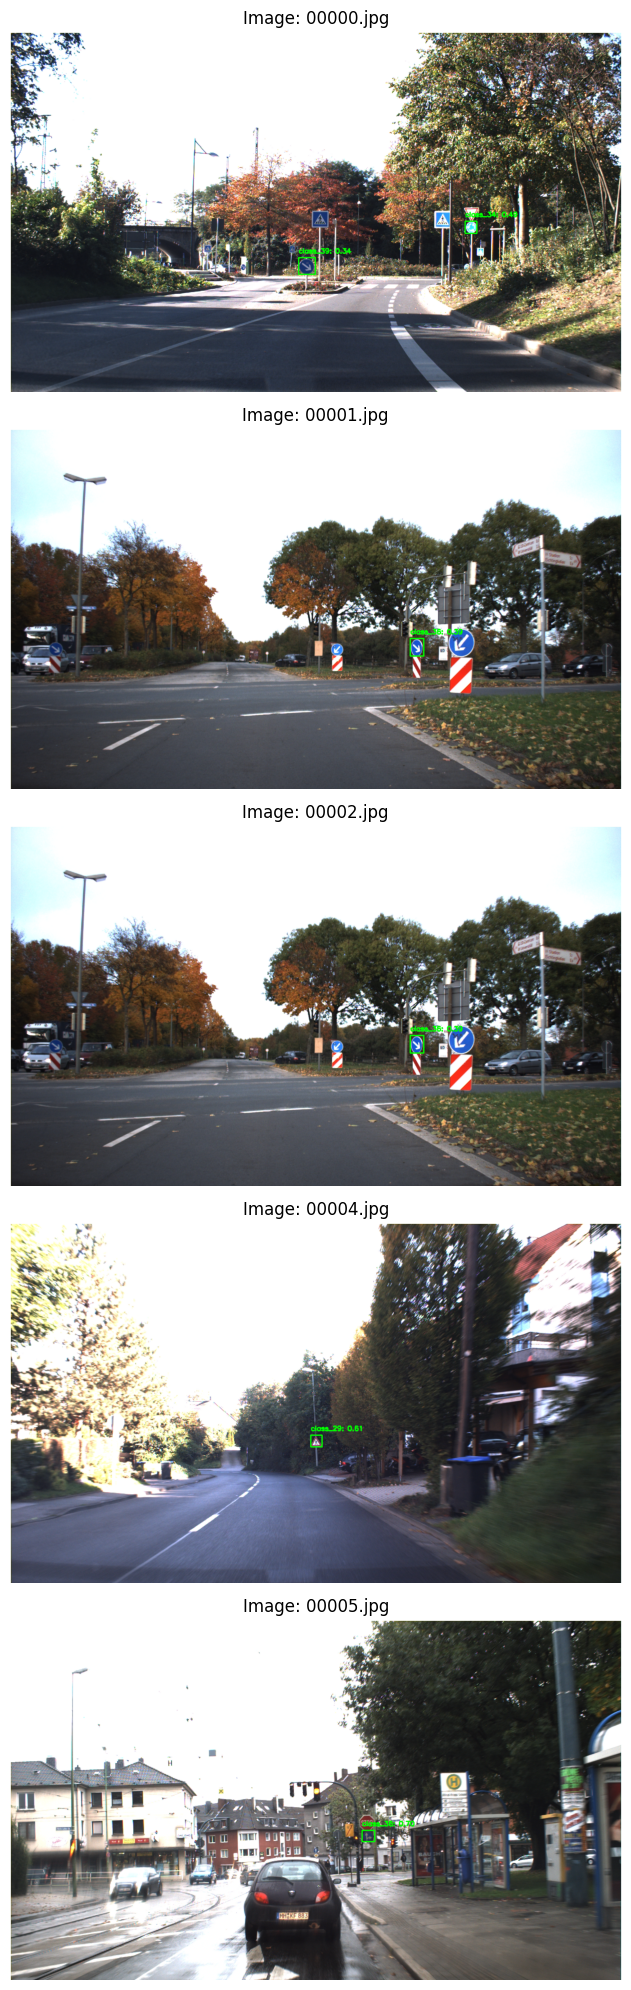

Saved 5 individual detection images to: /content/drive/My Drive/traffic_sign_results_fewshot_wo_augmentation_20250613_193604/detection_images


In [ ]:
# Evaluate model and save results
results = evaluate_detection_model(
    model, yaml_path,
    results_dir,
    show_images=True, max_images=5
)

Using results directory: /content/drive/My Drive/traffic_sign_results_fewshot_wo_augmentation_20250519_210220_A100_20250519_211504/yolo_traffic_signs
Using CSV file: /content/drive/My Drive/traffic_sign_results_fewshot_wo_augmentation_20250519_210220_A100_20250519_211504/yolo_traffic_signs/results.csv
Available metrics columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']
Visualization saved to /content/drive/My Drive/traffic_sign_results_fewshot_wo_augmentation_20250519_210220_A100_20250519_211504/training_metrics.png


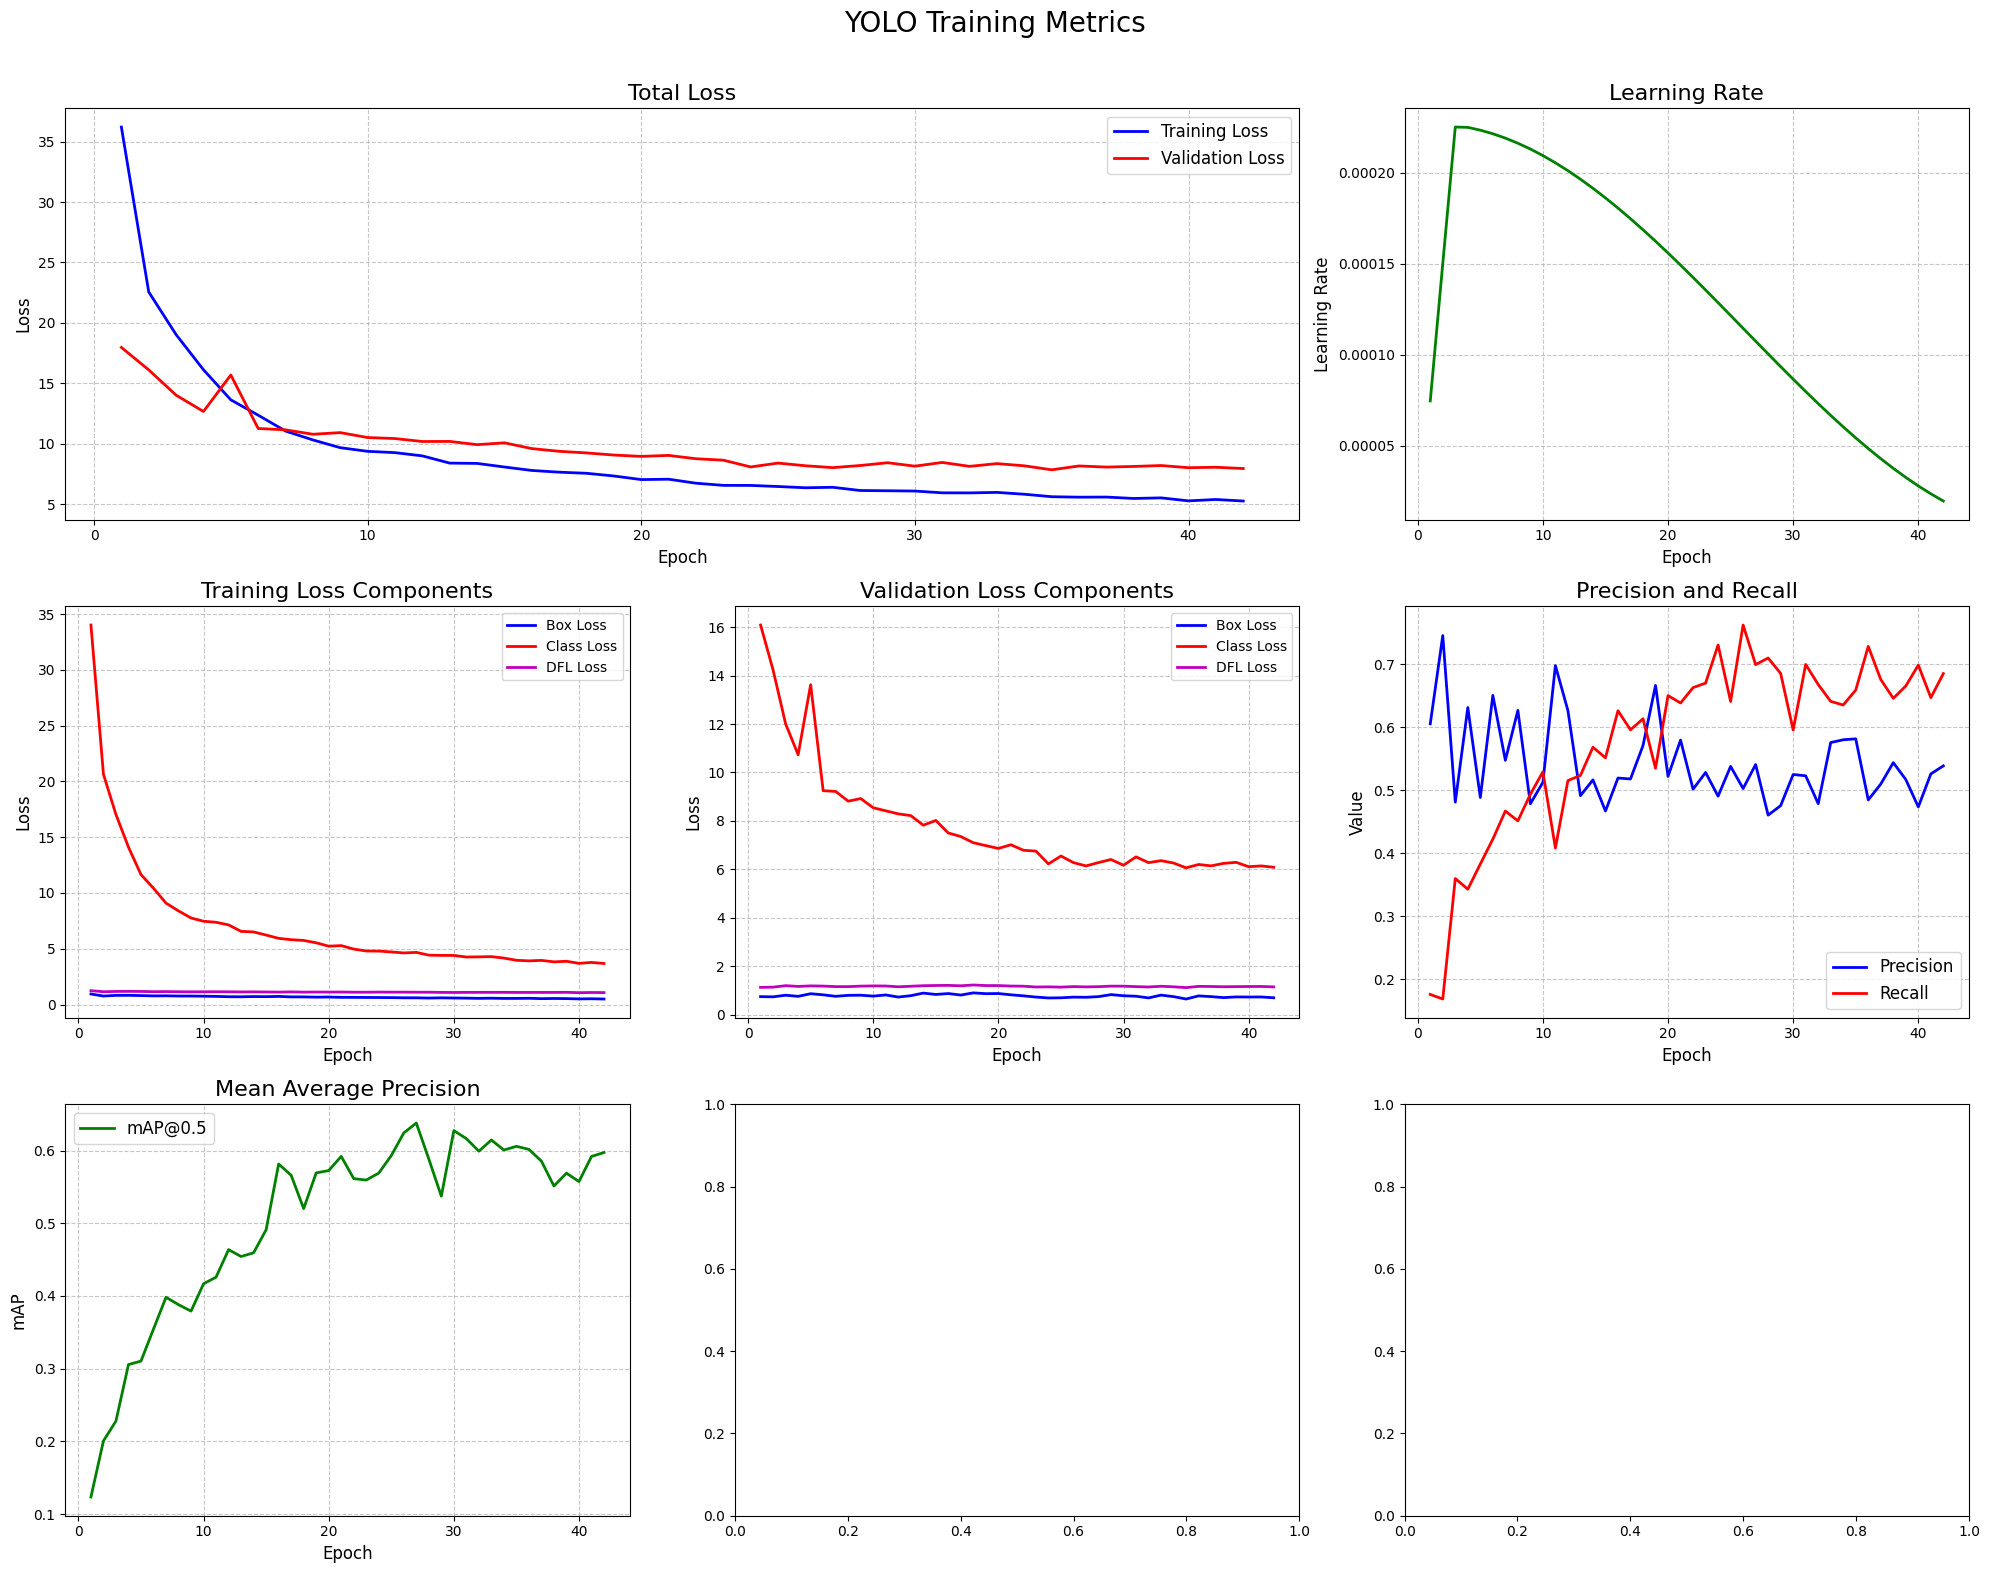

In [ ]:
# Get the actual YOLO results directory path
results_dir = "/content/drive/My Drive/traffic_sign_results_fewshot_wo_augmentation_20250519_210220_A100_20250519_211504"
yolo_dir = os.path.join(results_dir, "yolo_traffic_signs")

visualize_training_metrics(
    model_type='yolo',
    run_dir=yolo_dir,
    save_path=os.path.join(results_dir, "training_metrics.png")
);  # No

#6. Model Training - YOLO with augmentation

Here we need to reload the mapper because we have the option to test the model on a subset before fully training the model and this requires to ensure the class ID mapping is correctly maintained in your dataset info file.

In [ ]:
# Try to load it directly (this will run quickly since we're just loading basic data)
standard_data, few_shot_data, mapper = load_dataset_parameterized(x=x)
print("Mapper loaded successfully!")

Class Mapping: {0: 0, 16: 1, 20: 2, 21: 3, 24: 4, 27: 5, 29: 6, 32: 7, 34: 8, 36: 9, 39: 10, 40: 11, 41: 12, 42: 13}
Mapper loaded successfully!


In [ ]:
# Create timestamp-based results directory with descriptive name
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = f"/content/drive/My Drive/traffic_sign_results_fewshot_w_augmentation_{timestamp}"
os.makedirs(results_dir, exist_ok=True)
print(f"Created results directory: {results_dir}")

Created results directory: /content/drive/My Drive/traffic_sign_results_fewshot_w_augmentation_20250616_010939


In [ ]:
# Train the full YOLO model directly
print("\n=== STARTING FULL TRAINING (WITH AUGMENTATION) ===")
model, yaml_path = train_yolo_model_a100(
    train_data, val_data, test_data,
    mapper,
    results_dir,
    subset_mode=False
)


=== STARTING FULL TRAINING (WITH AUGMENTATION) ===
Created A100 results directory: /content/drive/My Drive/traffic_sign_results_fewshot_w_augmentation_20250616_010939_A100_20250616_010941
🗑️ Cleared existing dataset directory
🔧 Preparing datasets for Ultralytics...


Preparing test: 100%|██████████| 34/34 [00:01<00:00, 23.46it/s]


✅ Created dataset configuration at /content/traffic_sign_data/dataset.yaml
Class weights calculated from training data:
  Class 0 (Speed limit 20): 32 samples, weight = 1.50
  Class 1 (No trucks): 63 samples, weight = 0.76
  Class 2 (Bend right): 74 samples, weight = 0.65
  Class 3 (Bend): 32 samples, weight = 1.50
  Class 4 (Road narrows): 32 samples, weight = 1.50
  Class 5 (Pedestrian crossing): 31 samples, weight = 1.54
  Class 6 (Cycles crossing): 17 samples, weight = 2.82
  Class 7 (Restriction ends): 47 samples, weight = 1.02
  Class 8 (Go left): 75 samples, weight = 0.64
  Class 9 (Go right or straight): 65 samples, weight = 0.74
  Class 10 (Keep left): 48 samples, weight = 1.00
  Class 11 (Roundabout): 48 samples, weight = 1.00
  Class 12 (Restriction ends (overtaking)): 52 samples, weight = 0.92
  Class 13 (Restriction ends (overtaking trucks)): 54 samples, weight = 0.89

=== Training YOLOv8x Model on A100 with Critical Imbalance Handling ===
Ultralytics 8.3.155 🚀 Python-3.11

train: Scanning /content/traffic_sign_data/train/labels... 670 images, 0 backgrounds, 0 corrupt: 100%|██████████| 670/670 [00:03<00:00, 185.85it/s]

train: New cache created: /content/traffic_sign_data/train/labels.cache



train: Caching images (2.0GB Disk): 100%|██████████| 670/670 [00:07<00:00, 93.95it/s] 

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 431.5±47.5 MB/s, size: 1463.2 KB)


val: Scanning /content/traffic_sign_data/val/labels... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<00:00, 156.26it/s]

val: New cache created: /content/traffic_sign_data/val/labels.cache



val: Caching images (0.1GB Disk): 100%|██████████| 23/23 [00:01<00:00, 15.06it/s]


Plotting labels to /content/drive/My Drive/traffic_sign_results_fewshot_w_augmentation_20250616_010939_A100_20250616_010941/yolo_traffic_signs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000556, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 8 dataloader workers
Logging results to /content/drive/My Drive/traffic_sign_results_fewshot_w_augmentation_20250616_010939_A100_20250616_010941/yolo_traffic_signs
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/84 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 126.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 50.88 MiB is free. Process 305208 has 39.49 GiB memory in use. Of the allocated memory 38.78 GiB is allocated by PyTorch, and 189.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Evaluate model and save results
results = evaluate_detection_model(
    model, yaml_path,
    results_dir,
    show_images=True, max_images=5
)

NameError: name 'model' is not defined

Using results directory: /content/drive/My Drive/traffic_sign_results_fewshot_w_augmentation_20250520_205732_A100_20250520_210435/yolo_traffic_signs
Using CSV file: /content/drive/My Drive/traffic_sign_results_fewshot_w_augmentation_20250520_205732_A100_20250520_210435/yolo_traffic_signs/results.csv
Available metrics columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']
Visualization saved to /content/drive/My Drive/traffic_sign_results_fewshot_w_augmentation_20250520_205732_A100_20250520_210435/training_metrics.png


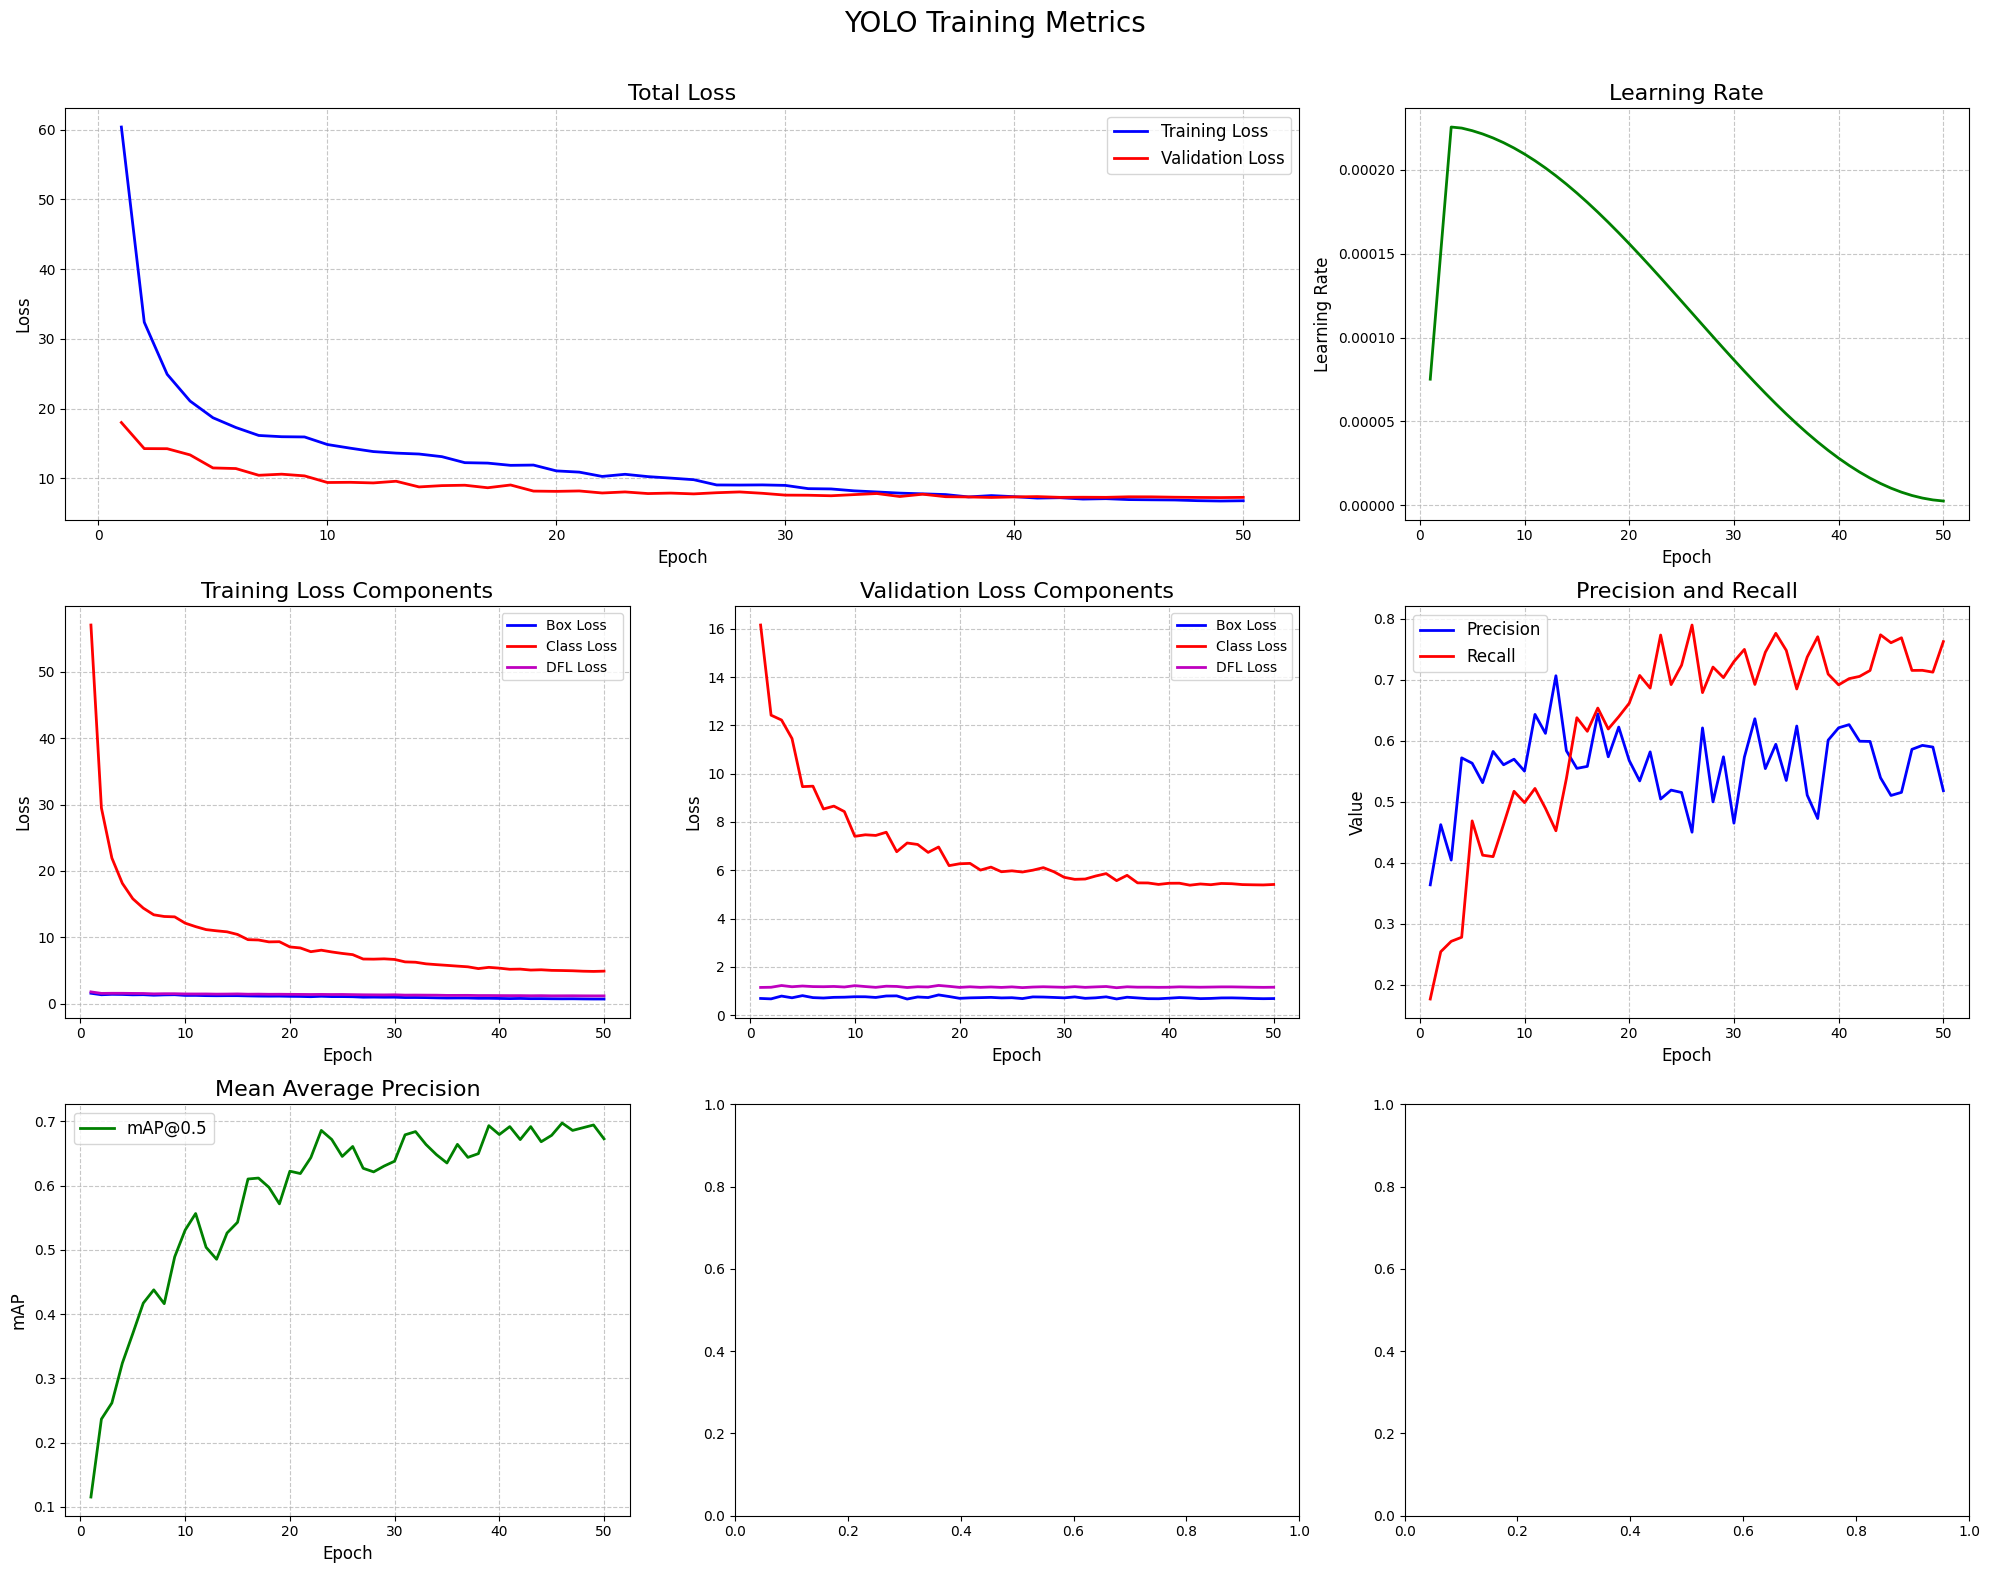

In [ ]:
# Get the actual YOLO results directory path
results_dir = "/content/drive/My Drive/traffic_sign_results_fewshot_w_augmentation_20250520_205732_A100_20250520_210435"
yolo_dir = os.path.join(results_dir, "yolo_traffic_signs")

visualize_training_metrics(
    model_type='yolo',
    run_dir=yolo_dir,
    save_path=os.path.join(results_dir, "training_metrics.png")
);  # No

#8. Model Evaluation and Conclusion

Compare the performance of YOLO without augmentation and with augmentation on the few-shot classes.